In [1]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import pandas as pd
import tensorflow as tf

categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
        'talk.politics.guns',
        'sci.electronics',
        'rec.autos',
        'rec.sport.baseball',
        'rec.motorcycles',
        'talk.politics.misc'
    ]
remove = ("headers", "footers", "quotes")

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
target_names = data_train.target_names


In [2]:
target_names

['alt.atheism',
 'comp.graphics',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'sci.electronics',
 'sci.space',
 'talk.politics.guns',
 'talk.politics.misc',
 'talk.religion.misc']

In [3]:
import re

def clean_text(string):
    val = re.sub(' +', ' ', re.sub('\W', ' ', string)).strip().lower()
    return val

train_text_list = [clean_text(val) for val in data_train.data]
test_text_list = [clean_text(val) for val in data_test.data]

In [4]:
token_series = pd.Series([token for doc in train_text_list for token in doc.split(' ')]).value_counts()
token_series.head(20)

the     48025
to      24338
of      21510
a       21257
and     18924
i       15181
in      13910
is      13806
that    13579
it      10948
you      9239
for      8963
on       6697
this     6556
s        6432
be       6212
have     6028
are      6014
not      5676
t        5536
dtype: int64

In [5]:
VOCAB_SIZE = token_series.gt(20).sum()
VOCAB_SIZE

4364

In [6]:
from tensorflow.keras.preprocessing import text, sequence


tokenizer = text.Tokenizer(num_words=VOCAB_SIZE + 1, oov_token='#OOV')
tokenizer.fit_on_texts(train_text_list)

In [7]:
list_tokenized_train = tokenizer.texts_to_sequences(train_text_list)
list_tokenized_test = tokenizer.texts_to_sequences(test_text_list)


In [8]:
len_series = pd.Series([len(val) for val in list_tokenized_train])
MAX_LEN = int(len_series.quantile(0.95))
MAX_LEN

564

In [9]:
X_train_ragged = tf.ragged.constant(list_tokenized_train)
X_test_ragged = tf.ragged.constant(list_tokenized_test)

In [10]:
X_train = sequence.pad_sequences(list_tokenized_train, padding='pre', maxlen=MAX_LEN)
X_test = sequence.pad_sequences(list_tokenized_test, padding='pre', maxlen=MAX_LEN)

In [11]:
y_train = np.array(data_train.target)
y_test = np.array(data_test.target)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5425, 564), (3611, 564), (5425,), (3611,))

In [12]:
Xtrain=pd.DataFrame(X_train)
Xtest=pd.DataFrame(X_test)

In [13]:
X = pd.concat([Xtrain, Xtest])
X.shape

(9036, 564)

In [14]:
X

,0,1,2,3,4,5,6,7,8,9,...,554,555,556,557,558,559,560,561,562,563
0,0,0,0,0,0,0,0,0,0,0,...,1,4213,8,2,461,4,15,1,814,1
1,0,0,0,0,0,0,0,0,0,0,...,26,59,6,12,1930,1,9,676,5,1
2,0,0,0,0,0,0,0,0,0,0,...,9,49,110,27,32,71,120,109,5,1
3,0,0,0,0,0,0,0,0,0,0,...,1,39,2,1,3785,14,45,3008,1,1
4,0,0,0,0,0,0,0,0,0,0,...,166,54,114,5,836,86,132,392,22,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606,0,0,0,0,0,0,0,0,0,0,...,49,7,55,21,1515,13,1,148,12,400
3607,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,86,1,46,5,1674
3608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3609,0,0,0,0,0,0,0,0,0,0,...,199,320,94,4,2,891,142,3,2192,39


In [15]:
Ytrain=pd.DataFrame(y_train)
Ytest=pd.DataFrame(y_test)
Y = pd.concat([Ytrain, Ytest])
Y

,0
0,5
1,3
2,7
3,7
4,2
...,...
3606,8
3607,1
3608,2
3609,6


In [16]:
df= pd.concat([X, Y], axis=1)
df.shape

(9036, 565)

In [17]:
df['e'] = X.sum(axis=1)
df['e']

0        55023
1         4401
2        40224
3       111974
4        80369
         ...  
3606    202245
3607      1812
3608         0
3609     40599
3610     43265
Name: e, Length: 9036, dtype: int64

In [18]:
(df['e'] == 0).sum(axis=0)

287

In [19]:
df1=df[df["e"]==0].index
df2=df.drop(df1)
df2.shape


(8517, 566)

In [21]:
train=np.column_stack((X_train, y_train))



In [22]:
train2 = train[~np.all(X_train == 0, axis = 1)]
train2.shape

(5253, 565)

In [25]:
test=np.column_stack((X_test, y_test))


In [23]:
X_train=train2[:,0:-1]
y_train=train2[:,-1]

In [26]:
test2 = test[~np.all(X_test == 0, axis = 1)]
test2.shape

(3496, 565)

In [27]:
X_test=test2[:,0:-1]
y_test=test2[:,-1]

#Tareas
- Entrena una BIGRU bidireccional con densas encima
- Entrena DAN sobre tensores ragged
- Aporta los rendimientos de ambos en train y test, así como su curva de entrenamiento, y el classification report entre categorías
- Genera una representación bidimensional basada en la proyección UMAP sobre las capas de encoding, crea un clustering con K grupos a elegir (mayor que el número de categorías trabajadas), aplicado sobre la capa representacional, y observa la relación entre las etiquetas reales y las etiquetas que el clustering ofrece, hazlo tanto para la representación obtenida por la red recurrente como para la representación que se genera con la DAN. Compara los resultados, ¿ cuál ofrece una mejor representación?

In [28]:
X_train

array([[  0,   0,   0, ...,   1, 814,   1],
       [  0,   0,   0, ..., 676,   5,   1],
       [  0,   0,   0, ..., 109,   5,   1],
       ...,
       [  0,   0,   0, ..., 629, 260, 373],
       [  0,   0,   0, ...,   2,   1,   1],
       [  0,   0,   0, ...,  25,   1,  79]])

In [29]:
np.unique(y_train) #Como parte del problema de los nan en la DAN he probado a ver si era problema de que faltara algun label (visto en un foro)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [30]:
y_train.dtype #Tambien he probado a ver si eran tipos de datos diferentes, pero he leido que los int64 son admitidos en los int32 y ademas lo he probado y sigue saliendo nan.

dtype('int64')

In [31]:
y_train32=y_train.astype(np.int32) #probe con esto

In [32]:
X_train64 = X_train.astype(np.int64) #tambien probe a la inversa, pasarlo todo a 64 pero los ragged no soportan la funcion astype.
X_train64.dtype

dtype('int64')

In [33]:
X_train_ragged.dtype


tf.int32

In [34]:
X_test_ragged.dtype

tf.int32

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, concatenate, Embedding
from tensorflow.keras.layers import GRU, Bidirectional, GlobalMaxPool1D, Dropout, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score

In [36]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(y_train.reshape(-1,1)).shape

(5253, 10)

In [37]:
ytest=ohe.fit_transform(y_test.reshape(-1,1)).shape

In [38]:
N_CATEGORIES=10

In [110]:
def get_full_bidirectional_model(embed_size_n_feat,
                                 n_categories,
                                 vocab_size,
                                 input_shape,
                                 n_neurons,
                                 dropout_rate=0.2,
                                 opt_alg='nadam'
                                 ):
    
    # encoder
    inp = Input(shape=(input_shape,))
    x = Embedding(vocab_size, embed_size_n_feat)(inp)
    x = Bidirectional(GRU(n_neurons, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    
    # decoder
    x = Dropout(dropout_rate)(x)
    x = Dense(n_neurons, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    
    x = Dense(n_categories, activation="softmax")(x)

    modelb = Model(inputs=inp, outputs=x)
    modelb.compile(loss='categorical_crossentropy',
                  optimizer=opt_alg,metrics=['accuracy'])

    return modelb

modelb = get_full_bidirectional_model(input_shape=MAX_LEN, 
                                     n_categories=N_CATEGORIES,
                                     n_neurons=10, 
                                     embed_size_n_feat=32, 
                                     vocab_size=VOCAB_SIZE + 1)
modelb.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 564)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 564, 32)           139680    
                                                                 
 bidirectional_1 (Bidirectio  (None, 564, 20)          2640      
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 20)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_8 (Dense)             (None, 10)                210 

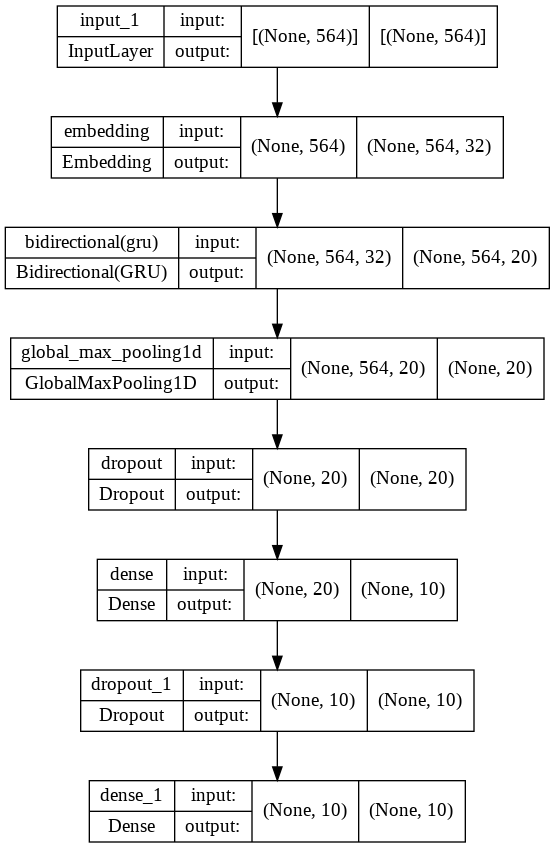

In [40]:
from tensorflow.keras.utils import plot_model

plot_model(modelb, show_shapes=True,to_file='model.png')

In [112]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
label_enc = OneHotEncoder(sparse=False)

WEIGHTS_PATH = 'bigru.hdf5'
#introducimos los chekpoints, estos guardan el mejor modelo después de actualizar todas las epochs
checkpoint = ModelCheckpoint(WEIGHTS_PATH, monitor='val_loss', verbose=0, save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

hist = modelb.fit(X_train, 
                  ohe.transform(y_train.reshape(-1,1)),
                  batch_size=2 ** 6,
                  epochs=1000, 
                  validation_split=0.1,
                  callbacks=[early_stop, checkpoint])

Epoch 1/1000
74/74 [==============================] - 36s 492ms/step - loss: 2.2919 - accuracy: 0.1314 - val_loss: 2.2750 - val_accuracy: 0.1901
Epoch 2/1000
74/74 [==============================] - 35s 479ms/step - loss: 2.2220 - accuracy: 0.2069 - val_loss: 2.1229 - val_accuracy: 0.3232
Epoch 3/1000
74/74 [==============================] - 36s 482ms/step - loss: 2.0088 - accuracy: 0.3063 - val_loss: 1.8222 - val_accuracy: 0.4734
Epoch 4/1000
74/74 [==============================] - 35s 477ms/step - loss: 1.7420 - accuracy: 0.4267 - val_loss: 1.5704 - val_accuracy: 0.5570
Epoch 5/1000
74/74 [==============================] - 36s 484ms/step - loss: 1.5298 - accuracy: 0.4853 - val_loss: 1.4112 - val_accuracy: 0.5932
Epoch 6/1000
74/74 [==============================] - 37s 502ms/step - loss: 1.3720 - accuracy: 0.5327 - val_loss: 1.3134 - val_accuracy: 0.6046
Epoch 7/1000
74/74 [==============================] - 35s 474ms/step - loss: 1.2386 - accuracy: 0.5775 - val_loss: 1.2454 - val_ac

In [115]:
modelb.load_weights(WEIGHTS_PATH)

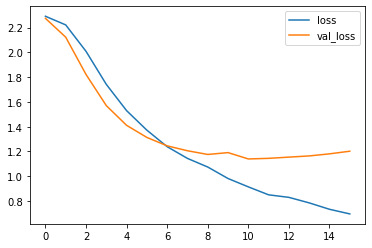

In [116]:
hist_df = pd.DataFrame(hist.history)
hist_df[['loss', 'val_loss']].plot()

In [117]:
ohe.categories_[0]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [118]:
y_pred_proba = modelb.predict(X_test)
y_pred = pd.DataFrame(y_pred_proba, columns=ohe.categories_[0]).idxmax(axis=1)

In [46]:
y_pred.shape

(3496,)

In [47]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.62      0.49       311
           1       0.71      0.76      0.73       384
           2       0.60      0.61      0.60       374
           3       0.73      0.63      0.68       386
           4       0.79      0.82      0.80       382
           5       0.60      0.60      0.60       382
           6       0.72      0.70      0.71       377
           7       0.49      0.57      0.53       353
           8       0.35      0.37      0.36       303
           9       0.12      0.01      0.02       244

    accuracy                           0.59      3496
   macro avg       0.55      0.57      0.55      3496
weighted avg       0.58      0.59      0.58      3496



In [48]:
roc_auc_score(pd.get_dummies(y_test), y_pred_proba)

0.9143620235878702

In [49]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.5681486595031389

#DAN model

In [53]:
y_train_ohe = ohe.transform(y_train.reshape(-1,1))
y_test_ohe = ohe.transform(y_test.reshape(-1,1))


In [54]:
ragged_train_tensor = tf.ragged.constant(X_train)
ragged_test_tensor = tf.ragged.constant(X_test)
ragged_train_tensor.dtype

tf.int32

In [55]:
Yragged_train_tensor = tf.ragged.constant(y_test_ohe) #Como parte de los esfuerzos para resolver error de los nan he probado a pasar el Ytrain a tensor... sin exito.

In [56]:
Y2ragged_train_tensor = tf.ragged.constant(y_test)

In [57]:
ragged_train_tensor.shape, ragged_test_tensor.shape

(TensorShape([5253, None]), TensorShape([3496, None]))

In [58]:
y_test.shape

(3496,)

In [59]:
ragged_train_tensor.to_tensor(shape=(None, 10))

<tf.Tensor: shape=(5253, 10), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

In [60]:
import tensorflow as tf


class CustomDataGen(tf.keras.utils.Sequence):  #Para ajustar a nuestro caso
    
    def __init__(self, X, y,
                 batch_size,
                 dropout_rate=0.3,
                 shuffle=True):
        
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.shuffle = shuffle
        self.n = X.shape[0]
    
    def on_epoch_end(self):
        if self.shuffle:
            index_to_shuffle = tf.random.shuffle(tf.range(self.n))
            self.X = tf.gather(self.X, index_to_shuffle)
            self.y = tf.gather(self.y, index_to_shuffle)
    

    def ragged_sample(self, x):
        length = tf.shape(x)[0]
        float_length = tf.cast(length, dtype=tf.float32)
        sample_size = tf.cast(tf.math.ceil(self.dropout_rate * float_length), 
                              dtype=tf.int32)
        val = tf.gather(x, tf.random.shuffle(tf.range(length))[:sample_size])
        return val
    
    def _sample_from_ragged(self, rt):
        val = tf.map_fn(self.ragged_sample, rt)
        return val

    def __getitem__(self, index):
        
        batch_X = self.X[index * self.batch_size:(index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]
#         print("SHAPE CHECK: ", batch_X.shape, batch_y.shape)
        batch_X = self._sample_from_ragged(batch_X)
#         print("SHAPE CHECK: ", batch_X.shape, batch_y.shape)
       
        return batch_X, batch_y
    
    def __len__(self):
        return self.n // self.batch_size

In [61]:
from pickle import TRUE
import tensorflow.keras.layers as layers
from tensorflow.python.eager import context


def get_dan_model(embed_size_n_feat,
                  n_categories,
                  vocab_size,
                  n_neurons_list=[10, 32],
                  dropout_rate=0.2,
                  opt_alg='adam'):

    inp = Input(shape=(None, ), ragged=True, dtype=tf.int32)
    x = Embedding(vocab_size, embed_size_n_feat)(inp)
    x = layers.GlobalAveragePooling1D()(x)

    for n_neurons in n_neurons_list:
        x = Dense(n_neurons, activation="relu")(x)

    x = Dense(n_categories, activation="softmax")(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=opt_alg)

    return model


modeldan = get_dan_model(embed_size_n_feat=32,
                      n_categories=N_CATEGORIES,
                      dropout_rate=0.2,
                      n_neurons_list=[10, 32],
                      vocab_size=VOCAB_SIZE + 1,
                      opt_alg='adam')

modeldan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 32)          139680    
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
 dense_3 (Dense)             (None, 32)                352       
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                           

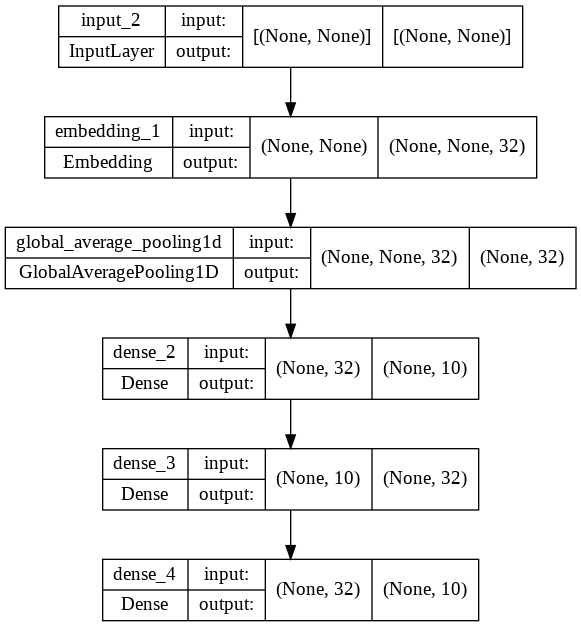

In [62]:
plot_model(modeldan, show_shapes=True)

In [63]:
custom_gen = CustomDataGen(X=ragged_train_tensor, 
                           y=y_train_ohe,
                           dropout_rate=0.3,
                           batch_size=64, 
                           shuffle=False)

In [64]:
from tensorflow.keras.callbacks import EarlyStopping


es_callback = EarlyStopping('val_loss', patience=20, restore_best_weights=True, verbose=True)

history = modeldan.fit(custom_gen,                      
                    validation_data=(ragged_test_tensor, y_test_ohe),
                    callbacks=[es_callback],
                    epochs=2000000)

Epoch 1/2000000
82/82 [==============================] - 12s 133ms/step - loss: 2.2961 - val_loss: 2.2911
Epoch 2/2000000
82/82 [==============================] - 9s 113ms/step - loss: 2.2830 - val_loss: 2.2774
Epoch 3/2000000
82/82 [==============================] - 9s 115ms/step - loss: 2.2609 - val_loss: 2.2501
Epoch 4/2000000
82/82 [==============================] - 10s 119ms/step - loss: 2.2111 - val_loss: 2.1836
Epoch 5/2000000
82/82 [==============================] - 10s 119ms/step - loss: 2.1206 - val_loss: 2.0787
Epoch 6/2000000
82/82 [==============================] - 10s 122ms/step - loss: 2.0211 - val_loss: 1.9899
Epoch 7/2000000
82/82 [==============================] - 10s 116ms/step - loss: 1.9228 - val_loss: 1.8973
Epoch 8/2000000
82/82 [==============================] - 9s 115ms/step - loss: 1.8500 - val_loss: 1.8318
Epoch 9/2000000
82/82 [==============================] - 9s 110ms/step - loss: 1.7738 - val_loss: 1.7629
Epoch 10/2000000
82/82 [==========================

In [65]:
from pickle import TRUE
import tensorflow.keras.layers as layers
from tensorflow.python.eager import context


def get_dan_model(embed_size_n_feat,
                  n_categories,
                  vocab_size,
                  n_neurons_list=[10, 32],
                  dropout_rate=0.2,
                  opt_alg='adam'):

    inp = Input(shape=(None, ), ragged=True, dtype=tf.int32)
    x = Embedding(vocab_size, embed_size_n_feat)(inp)
    x = layers.GlobalAveragePooling1D()(x)

    for n_neurons in n_neurons_list:
        x = Dense(n_neurons, activation="relu")(x)

    x = Dense(n_categories, activation="softmax")(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt_alg)

    return model


model2 = get_dan_model(embed_size_n_feat=32,
                      n_categories=N_CATEGORIES,
                      dropout_rate=0.2,
                      n_neurons_list=[10, 32],
                      vocab_size=VOCAB_SIZE + 1,
                      opt_alg='adam')

model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 32)          139680    
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
 dense_6 (Dense)             (None, 32)                352       
                                                                 
 dense_7 (Dense)             (None, 10)                330       
                                                           

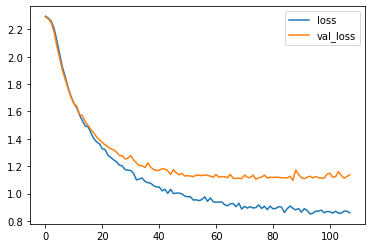

In [66]:
history_df = pd.DataFrame(history.history)
history_df.plot();

In [68]:
y_pred_proba = model.predict(ragged_test_tensor)
y_pred = pd.DataFrame(y_pred_proba, columns=ohe.categories_[0]).idxmax(axis=1)

In [69]:
y_pred.shape

(3496,)

In [70]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.62      0.49       311
           1       0.71      0.76      0.73       384
           2       0.60      0.61      0.60       374
           3       0.73      0.63      0.68       386
           4       0.79      0.82      0.80       382
           5       0.60      0.60      0.60       382
           6       0.72      0.70      0.71       377
           7       0.49      0.57      0.53       353
           8       0.35      0.37      0.36       303
           9       0.12      0.01      0.02       244

    accuracy                           0.59      3496
   macro avg       0.55      0.57      0.55      3496
weighted avg       0.58      0.59      0.58      3496



In [71]:
roc_auc_score(pd.get_dummies(y_test), y_pred_proba) #0.9699
# 0.97793

0.9143620235878702

In [72]:
balanced_accuracy_score(y_test, y_pred)

0.5681486595031389

Representar los modelos

DAN

In [74]:
def extract_encoder_from_keras_model(model, layer_output_number):
    
    encoder = Model(model.input, model.layers[layer_output_number].output)

    return encoder

In [75]:
encoder = extract_encoder_from_keras_model(model, -2)
encoder(ragged_train_tensor).shape

TensorShape([5253, 10])

In [76]:
embedding_arr = encoder(ragged_train_tensor)
embedding_arr.shape

TensorShape([5253, 10])

In [77]:
type(embedding_arr)

tensorflow.python.framework.ops.EagerTensor

In [81]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.1 MB/s 
     |████████████████████████████████| 1.1 MB 29.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=05ec55519ec864f77334a60c60ddad21d6fa3f3d5a3616f3895453eb230ad490
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=534d5312d910ea8df5de14181c7e53577a0784161a15d5f2d3ca02a538e40ed7
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [82]:
import umap

In [83]:
reducer = umap.UMAP(n_components=2, metric='cosine')
umap_embedding = reducer.fit_transform(embedding_arr)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [84]:
umap_embedding.shape

(5253, 2)

In [86]:
set = pd.Categorical(y_train).codes
set

array([5, 3, 7, ..., 4, 4, 2], dtype=int8)

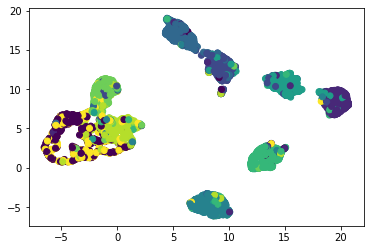

In [120]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=set);

In [98]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


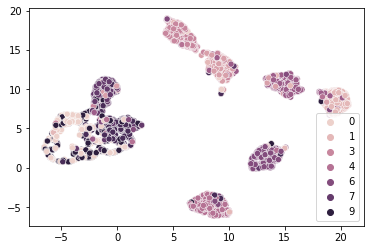

In [99]:
sns.scatterplot(umap_embedding[:, 0], umap_embedding[:, 1], hue=y_train)

BIGRU

In [121]:
def extract_encoder_from_keras_model(modelb, layer_output_number):
    
    encoderb = Model(modelb.input, modelb.layers[layer_output_number].output)

    return encoderb

In [122]:
encoderb = extract_encoder_from_keras_model(modelb, -2)
encoderb(ragged_train_tensor).shape

TensorShape([5253, 10])

In [123]:
embedding_arr = encoderb(ragged_train_tensor)
embedding_arr.shape

TensorShape([5253, 10])

In [124]:
embedding_arrb = encoderb(ragged_train_tensor)
embedding_arrb.shape

TensorShape([5253, 10])

In [125]:
reducer = umap.UMAP(n_components=2, metric='cosine')
umap_embeddingb = reducer.fit_transform(embedding_arrb)

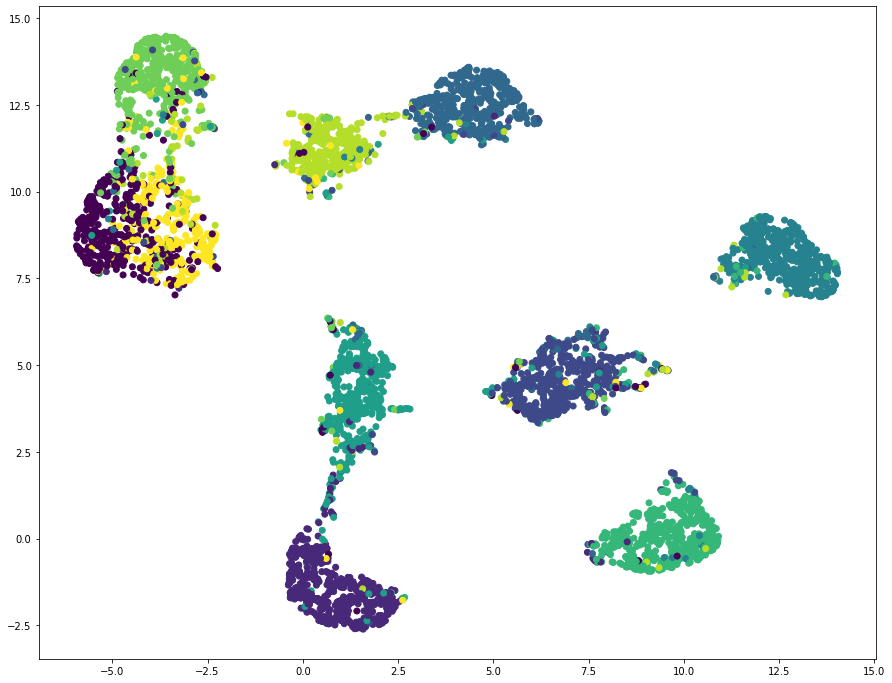

In [126]:
plt.figure(figsize=(15, 12))
plt.scatter(umap_embeddingb[:, 0], umap_embeddingb[:, 1], c=set);

DBSCAN

In [90]:
from sklearn.cluster import DBSCAN, KMeans

In [91]:
clustering_model = DBSCAN(eps=0.2, 
                min_samples=20,
                metric='cosine',
                n_jobs=-1)

clustering_model = KMeans(n_clusters=30)

In [92]:
clustering_model.fit(embedding_arr)

KMeans(n_clusters=30)

In [102]:
clustering_df = pd.DataFrame({'text': y_train,
                              'condition': y_train,
                              'label': clustering_model.labels_})

In [103]:
clustering_df.label.value_counts()

2     387
10    292
1     291
15    266
26    236
13    235
4     223
8     220
21    204
14    199
9     190
17    186
0     182
22    181
18    162
29    161
5     158
6     157
24    133
7     132
20    131
16    129
27    127
25    114
12    110
19    109
11    108
28     99
23     79
3      52
Name: label, dtype: int64

In [104]:
clustering_df.groupby('label').apply(lambda series: series.sample(np.min([10, series.shape[0]])))

text  condition  label
label                             
0     3190     5          5      0
      4175     5          5      0
      3294     5          5      0
      2772     5          5      0
      81       5          5      0
...          ...        ...    ...
29    1362     7          7     29
      1471     7          7     29
      4768     7          7     29
      2326     7          7     29
      1657     7          7     29

[300 rows x 3 columns]

In [105]:
clustering_df.groupby(['label', 'condition']).count()

text
label condition      
0     1             3
      2             3
      4             1
      5           175
1     0            76
...               ...
29    2             4
      3             3
      7           138
      8            12
      9             3

[133 rows x 1 columns]

In [106]:
from sklearn.metrics import normalized_mutual_info_score as nmi

In [107]:
nmi([0, 0, 2, 2], [0, 0, 1, 1])

1.0

In [108]:
nmi(labels_true=clustering_df.condition, labels_pred=clustering_df.label)

0.6450652337268498